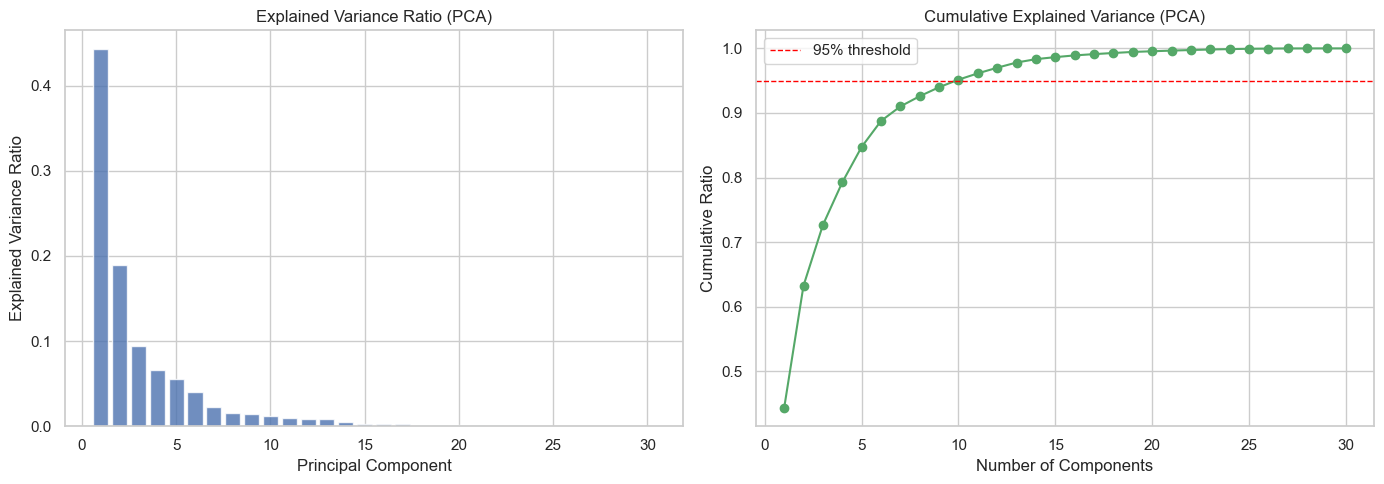

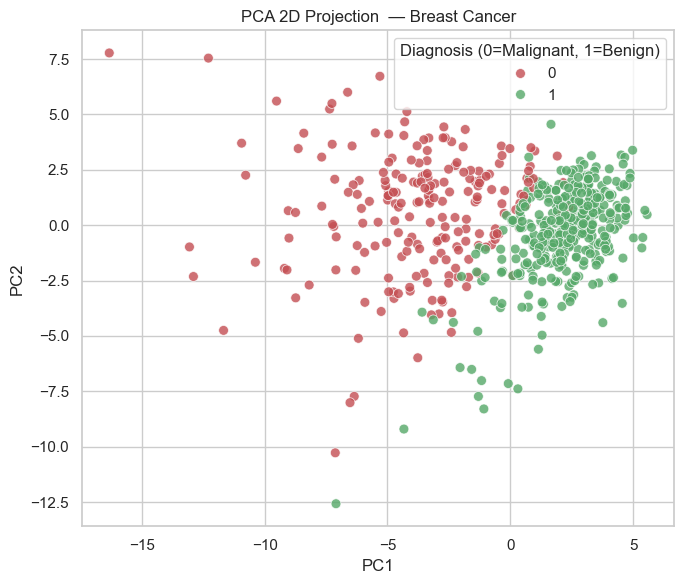

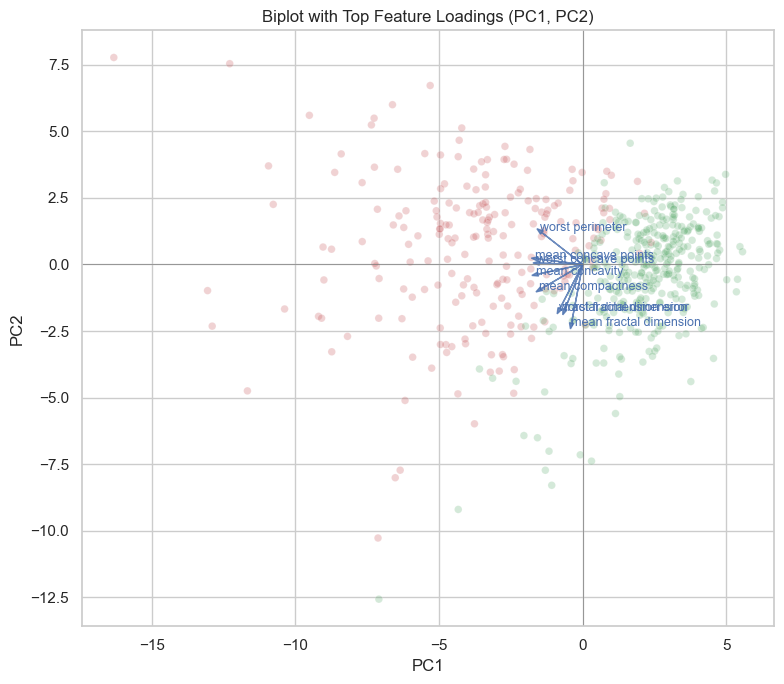

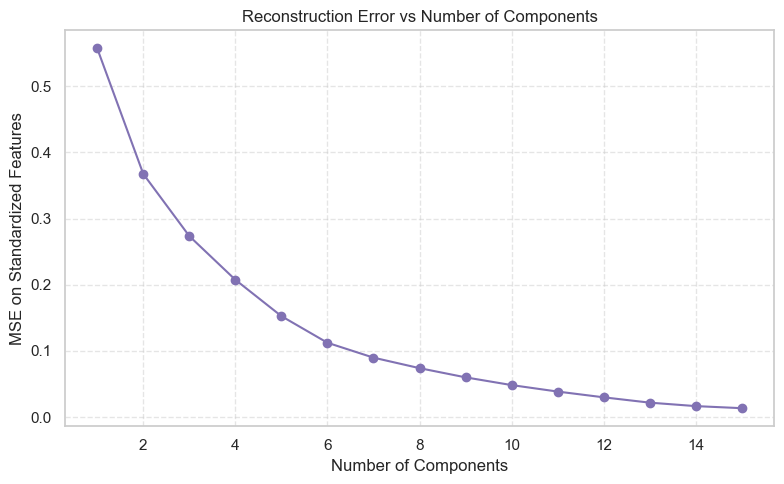

   PC  EVR_scratch  EVR_sklearn      abs_diff
0   1     0.442720     0.442720  4.440892e-16
1   2     0.189712     0.189712  8.326673e-17
2   3     0.093932     0.093932  1.249001e-16
3   4     0.066021     0.066021  1.249001e-16
4   5     0.054958     0.054958  6.245005e-17
5   6     0.040245     0.040245  2.081668e-17
6   7     0.022507     0.022507  1.734723e-17
7   8     0.015887     0.015887  2.428613e-17
8   9     0.013896     0.013896  2.428613e-17
9  10     0.011690     0.011690  1.387779e-17
Components to reach 80% variance (scratch): 5
Components to reach 90% variance (scratch): 7
Components to reach 95% variance (scratch): 10
Components to reach 99% variance (scratch): 17


In [ ]:
# PCA on Breast Cancer dataset: 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

# -----------------------------
# 1) Load data
# -----------------------------
data_bunch = load_breast_cancer()
X = data_bunch.data  
y = data_bunch.target  # 0 = malignant, 1 = benign
feature_names = data_bunch.feature_names

df = pd.DataFrame(X, columns=feature_names)
df['target'] = y


scaler = StandardScaler(with_mean=True, with_std=True)
X_std = scaler.fit_transform(X)  # zero mean, unit variance

def pca_from_scratch(X_centered, n_components=None):
    n_samples, n_features = X_centered.shape
    # economy SVD
    U, S, VT = np.linalg.svd(X_centered, full_matrices=False)
    components = VT  # shape (n_components_full, n_features)
    explained_variance = (S**2) / (n_samples - 1)
    explained_variance_ratio = explained_variance / explained_variance.sum()
    singular_values = S

    if n_components is not None:
        components = components[:n_components]
        explained_variance = explained_variance[:n_components]
        explained_variance_ratio = explained_variance_ratio[:n_components]
        singular_values = singular_values[:n_components]

    mean_ = np.zeros(n_features)  # already centered input
    return {
        "components_": components,
        "explained_variance_": explained_variance,
        "explained_variance_ratio_": explained_variance_ratio,
        "singular_values_": singular_values,
        "mean_": mean_
    }

scratch_full = pca_from_scratch(X_std, n_components=None)

# Transform and inverse-transform helpers
def pca_transform(X_centered, components):
    return X_centered @ components.T

def pca_inverse_transform(Z, components, mean):
    return Z @ components + mean

# -----------------------------
# 4) PCA with scikit-learn for validation
# -----------------------------
pca = PCA(n_components=None, svd_solver='auto', whiten=False)
Z_sklearn = pca.fit_transform(X_std)

# -----------------------------
# 5) Compare explained variance ratio (scratch vs sklearn)
# -----------------------------
evr_scratch = scratch_full["explained_variance_ratio_"]
evr_sklearn = pca.explained_variance_ratio_

# -----------------------------
# 6) Visualizations
# -----------------------------
sns.set(context="notebook", style="whitegrid", font_scale=1.0)
plt.rcParams["figure.figsize"] = (10, 6)

# 6.1 Scree plot and cumulative explained variance
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].bar(np.arange(1, len(evr_scratch)+1), evr_scratch, color="#4C72B0", alpha=0.8)
ax[0].set_title("Explained Variance Ratio (PCA)")
ax[0].set_xlabel("Principal Component")
ax[0].set_ylabel("Explained Variance Ratio")

cumvar = np.cumsum(evr_scratch)
ax[1].plot(np.arange(1, len(cumvar)+1), cumvar, marker="o", color="#55A868")
ax[1].axhline(0.95, color="red", linestyle="--", linewidth=1, label="95% threshold")
ax[1].set_title("Cumulative Explained Variance (PCA)")
ax[1].set_xlabel("Number of Components")
ax[1].set_ylabel("Cumulative Ratio")
ax[1].legend()

plt.tight_layout()
plt.show()

# 6.2 2D scatter on first two PCs
k = 2
components_2 = scratch_full["components_"][:k]
Z2 = pca_transform(X_std, components_2)
Z2_df = pd.DataFrame(Z2, columns=[f"PC{i+1}" for i in range(k)])
Z2_df["target"] = y

plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=Z2_df, x="PC1", y="PC2",
    hue="target",
    palette={0: "#C44E52", 1: "#55A868"},
    alpha=0.8, s=50
)
plt.title("PCA 2D Projection  — Breast Cancer")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Diagnosis (0=Malignant, 1=Benign)")
plt.tight_layout()
plt.show()


loadings = scratch_full["components_"][:2]  # shape (2, n_features)
loading_df = pd.DataFrame(loadings.T, index=feature_names, columns=["PC1", "PC2"])

top_n = 8
top_features = (
    loading_df.abs().assign(max_abs=lambda d: d.max(axis=1))
    .sort_values("max_abs", ascending=False)
    .head(top_n)
    .index
)
loading_top = loading_df.loc[top_features]

plt.figure(figsize=(8, 7))
sns.scatterplot(
    data=Z2_df, x="PC1", y="PC2",
    hue="target",
    palette={0: "#C44E52", 1: "#55A868"},
    alpha=0.25, s=30, legend=False
)
scale = 6.0  # arrow length scale for visibility
for feat in top_features:
    x, yv = loading_top.loc[feat, "PC1"], loading_top.loc[feat, "PC2"]
    plt.arrow(0, 0, scale*x, scale*yv, color="#4C72B0", alpha=0.8, width=0.003, head_width=0.15)
    plt.text(scale*x*1.05, scale*yv*1.05, feat, fontsize=9, color="#4C72B0")

plt.axhline(0, color="grey", linewidth=0.5)
plt.axvline(0, color="grey", linewidth=0.5)
plt.title("Biplot with Top Feature Loadings (PC1, PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

# 6.4 Reconstruction error vs number of components
max_k = min(X_std.shape)  # up to rank
errs = []
ks = list(range(1, 16))  # first 15 components for readability

for k in ks:
    comps_k = scratch_full["components_"][:k]
    Zk = pca_transform(X_std, comps_k)
    X_recon = pca_inverse_transform(Zk, comps_k, mean=np.zeros(X_std.shape[1]))
    err = mean_squared_error(X_std, X_recon)
    errs.append(err)

plt.figure(figsize=(8, 5))
plt.plot(ks, errs, marker="o", color="#8172B3")
plt.title("Reconstruction Error vs Number of Components")
plt.xlabel("Number of Components")
plt.ylabel("MSE on Standardized Features")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


compare = pd.DataFrame({
    "PC": np.arange(1, 11),
    "EVR_scratch": evr_scratch[:10],
    "EVR_sklearn": evr_sklearn[:10],
    "abs_diff": np.abs(evr_scratch[:10] - evr_sklearn[:10])
})
print(compare)


cum_scratch = np.cumsum(evr_scratch)
for cutoff in [0.80, 0.90, 0.95, 0.99]:
    k_cut = int(np.searchsorted(cum_scratch, cutoff) + 1)
    print(f"Components to reach {cutoff*100:.0f}% variance (scratch): {k_cut}")
